In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator

# Import from parent directory
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')))

from utils_amp import (
    amplitude_feature_map,
    flatten_image_to_vector,
    normalize_vector,
    simulate_statevector,
    verify_encoding,
    angles_from_amplitudes_real,
    build_parametric_amp_encoder,
    bind_encoder_angles,
    build_amp_feature_map,
    image_to_angles,
    images_to_angles_batch,
)
from utils import build_qcnn_circuit

np.set_printoptions(precision=4, suppress=True)

In [2]:
# Parametric amplitude encoder (fixed circuit) for EstimatorQNN
# Build a fixed 4-qubit parametric encoder and validate binding on a random image
n = 4
enc_qc, theta, enc_info = build_parametric_amp_encoder(n)
print("Parametric encoder: qubits=", enc_info["num_qubits"], "total_params=", enc_info["total_params"])

Parametric encoder: qubits= 4 total_params= 15


In [3]:
# Prepare a random 4x4 image, compute angles, bind, and verify fidelity
rng = np.random.default_rng(6)
img2 = rng.random((4, 4))
vec2 = flatten_image_to_vector(img2)
vec2_n, _ = normalize_vector(vec2)

angles = angles_from_amplitudes_real(vec2_n)
print("Angles shape:", angles.shape, "expected:", len(theta))

enc_bound = bind_encoder_angles(enc_qc, theta, angles)
sv_enc = simulate_statevector(enc_bound)
fid_p, l2_p = verify_encoding(vec2_n, sv_enc)

print(f"Parametric binding fidelity: {fid_p:.10f}")
print(f"Parametric binding L2 error: {l2_p:.3e}")

# Visual check: compare a few amplitudes
print("Target:", np.round(vec2_n, 4))
print("Prep'd:", np.round(sv_enc, 4))

Angles shape: (15,) expected: 15
Parametric binding fidelity: 1.0000000000
Parametric binding L2 error: 1.853e-16
Target: [0.2182+0.j 0.1392+0.j 0.1496+0.j 0.1518+0.j 0.4003+0.j 0.2565+0.j
 0.2734+0.j 0.1338+0.j 0.2756+0.j 0.0499+0.j 0.021 +0.j 0.3447+0.j
 0.0036+0.j 0.3968+0.j 0.3353+0.j 0.3183+0.j]
Prep'd: [0.2182+0.j 0.1392+0.j 0.1496+0.j 0.1518+0.j 0.4003+0.j 0.2565+0.j
 0.2734+0.j 0.1338+0.j 0.2756+0.j 0.0499+0.j 0.021 +0.j 0.3447+0.j
 0.0036+0.j 0.3968+0.j 0.3353+0.j 0.3183+0.j]


In [4]:
# Encode 3 images and get statevectors via AerSimulator (pure Qiskit run)
from qiskit_aer import AerSimulator
from qiskit import transpile

rng = np.random.default_rng(321)
images2 = [rng.random((4, 4)) for _ in range(3)]

backend = AerSimulator(method='statevector', device='CPU', max_parallel_threads=0)

for i, img in enumerate(images2):
    v = flatten_image_to_vector(img)
    v_n, _ = normalize_vector(v)
    ang = angles_from_amplitudes_real(v_n)

    # Bind parameters on the same fixed circuit
    circ = bind_encoder_angles(enc_qc, theta, ang)

    # Decompose/Transpile to Aer basis to avoid AnnotatedOperation issues
    circ_t = transpile(circ, backend=backend, optimization_level=0)

    # Request statevector from Aer
    c = circ_t.copy()
    c.save_statevector()
    res = backend.run(c).result()
    try:
        sv_aer = res.get_statevector(c)
    except Exception:
        sv_aer = res.data(0).get('statevector')

    fid, l2 = verify_encoding(v_n, sv_aer)
    print(f"[Aer] Image {i+1}: fidelity={fid:.12f}, L2={l2:.3e}")

[Aer] Image 1: fidelity=1.000000000000, L2=5.266e-16
[Aer] Image 2: fidelity=1.000000000000, L2=4.071e-16
[Aer] Image 3: fidelity=1.000000000000, L2=4.213e-16
[Aer] Image 2: fidelity=1.000000000000, L2=4.071e-16
[Aer] Image 3: fidelity=1.000000000000, L2=4.213e-16


## Verify build_dual_amp_feature_map

Test the dual amplitude encoder (8 qubits: 4 for rows + 4 for columns) with a random 4×4 image.

In [5]:
# Build the dual amplitude feature map (8 qubits total: 4 for rows, 4 for cols)
from utils_amp import build_dual_amp_feature_map, images_to_angles_batch_dual

num_pixels = 16  # 4x4 image
dual_fm, dual_params, dual_info = build_dual_amp_feature_map(num_pixels)

print("Dual Feature Map Info:")
print(f"  Total qubits: {dual_info['total_qubits']}")
print(f"  Qubits per half: {dual_info['num_qubits_each']}")
print(f"  Params per half: {dual_info['params_per_half']}")
print(f"  Total input params: {dual_info['total_input_params']}")
print(f"  Parameter names: rows='{dual_info['param_names']['rows']}', cols='{dual_info['param_names']['cols']}'")
print(f"\nCircuit has {dual_fm.num_qubits} qubits and {dual_fm.num_parameters} parameters")

Dual Feature Map Info:
  Total qubits: 8
  Qubits per half: 4
  Params per half: 15
  Total input params: 30
  Parameter names: rows='theta', cols='phi'

Circuit has 8 qubits and 30 parameters


In [6]:
# Generate a random 4x4 image and compute dual angles (row-major + col-major)
rng_dual = np.random.default_rng(42)
test_img = rng_dual.random((4, 4))

print("Test image (4×4):")
print(test_img)

# Compute angles for both row-major and column-major encoding
angles_dual = images_to_angles_batch_dual([test_img])[0]  # Get first sample
print(f"\nDual angles shape: {angles_dual.shape} (expected: {dual_info['total_input_params']})")
print(f"Angles[0:15] = rows encoding")
print(f"Angles[15:30] = columns encoding")

Test image (4×4):
[[0.774  0.4389 0.8586 0.6974]
 [0.0942 0.9756 0.7611 0.7861]
 [0.1281 0.4504 0.3708 0.9268]
 [0.6439 0.8228 0.4434 0.2272]]

Dual angles shape: (30,) (expected: 30)
Angles[0:15] = rows encoding
Angles[15:30] = columns encoding


In [7]:
# Bind the dual angles to the circuit and simulate with AerSimulator
from qiskit import transpile

# Create parameter binding dictionary
param_dict = {dual_params[i]: float(angles_dual[i]) for i in range(len(dual_params))}
bound_dual_circuit = dual_fm.assign_parameters(param_dict)

# Transpile for AerSimulator
backend_dual = AerSimulator(method='statevector', device='CPU', max_parallel_threads=0)
circ_dual_t = transpile(bound_dual_circuit, backend=backend_dual, optimization_level=0)

# Get statevector
circ_dual_copy = circ_dual_t.copy()
circ_dual_copy.save_statevector()
result_dual = backend_dual.run(circ_dual_copy).result()

try:
    sv_dual = result_dual.get_statevector(circ_dual_copy)
except Exception:
    sv_dual = result_dual.data(0).get('statevector')

sv_dual_array = np.array(sv_dual)
print(f"Statevector shape: {sv_dual_array.shape} (expected: 2^8 = 256)")
print(f"Statevector norm: {np.linalg.norm(sv_dual_array):.10f} (should be ~1.0)")

Statevector shape: (256,) (expected: 2^8 = 256)
Statevector norm: 1.0000000000 (should be ~1.0)


In [8]:
# Verify the encoding by checking the structure
# For dual encoding: The function currently encodes the SAME 16 pixels twice:
#   - First 4 qubits: row-major flattening of 4x4 image
#   - Second 4 qubits: column-major flattening of 4x4 image
# This creates a tensor product |rows⟩ ⊗ |cols⟩ where both encode the same image differently

from utils_amp import flatten_image_to_vector, flatten_image_to_vector_col_major

# Expected row-major encoding (first 4 qubits control amplitudes 0-15)
vec_rows = flatten_image_to_vector(test_img)
vec_rows_n, _ = normalize_vector(vec_rows)

# Expected column-major encoding (second 4 qubits control amplitudes in blocks)
vec_cols = flatten_image_to_vector_col_major(test_img)
vec_cols_n, _ = normalize_vector(vec_cols)

print("Row-major target (normalized):")
print(np.round(vec_rows_n.real, 4))
print("\nColumn-major target (normalized):")
print(np.round(vec_cols_n.real, 4))
print("\n" + "="*60)

# The 8-qubit state is a tensor product: |rows⟩ ⊗ |cols⟩
# So amplitude[i*16 + j] = rows[i] * cols[j] for i,j in [0,15]
# Let's reconstruct the expected 256-element statevector
expected_sv = np.outer(vec_rows_n, vec_cols_n).flatten()

# Compare
fidelity_dual = np.abs(np.vdot(expected_sv, sv_dual_array))**2
l2_error_dual = np.linalg.norm(expected_sv - sv_dual_array)

print(f"\nDual encoding verification:")
print(f"  Fidelity: {fidelity_dual:.12f} (should be ~1.0)")
print(f"  L2 error: {l2_error_dual:.3e} (should be ~0)")

# Debug: Check if the issue is with qubit ordering
# Maybe the circuit uses opposite qubit ordering?
expected_sv_swapped = np.outer(vec_cols_n, vec_rows_n).flatten()
fidelity_swapped = np.abs(np.vdot(expected_sv_swapped, sv_dual_array))**2
print(f"\n  Fidelity (cols⊗rows): {fidelity_swapped:.12f}")

# Also check if maybe it's interpreting the qubits in reverse order (big-endian vs little-endian)
# Reshape and check different permutations
sv_matrix = sv_dual_array.reshape(16, 16)
expected_matrix = np.outer(vec_rows_n, vec_cols_n)

print(f"\n  Matrix Frobenius norm diff: {np.linalg.norm(sv_matrix - expected_matrix):.3e}")
print(f"  Matrix transpose Frobenius diff: {np.linalg.norm(sv_matrix - expected_matrix.T):.3e}")

if fidelity_dual > 0.9999:
    print("\n✓ Dual encoding is CORRECT!")
elif fidelity_swapped > 0.9999:
    print("\n✓ Dual encoding works but qubit order is swapped!")
else:
    print("\n✗ Warning: Dual encoding may have issues")
    print("\nInvestigating qubit ordering...")


Row-major target (normalized):
[0.2984 0.1692 0.331  0.2688 0.0363 0.3761 0.2934 0.303  0.0494 0.1736
 0.1429 0.3573 0.2482 0.3172 0.1709 0.0876]

Column-major target (normalized):
[0.2984 0.0363 0.0494 0.2482 0.1692 0.3761 0.1736 0.3172 0.331  0.2934
 0.1429 0.1709 0.2688 0.303  0.3573 0.0876]


Dual encoding verification:
  Fidelity: 0.530247019589 (should be ~1.0)
  L2 error: 7.373e-01 (should be ~0)

  Fidelity (cols⊗rows): 1.000000000000

  Matrix Frobenius norm diff: 7.373e-01
  Matrix transpose Frobenius diff: 8.486e-16

✓ Dual encoding works but qubit order is swapped!


In [9]:
# Let's deeply inspect the statevector structure to understand qubit ordering
# In Qiskit, qubit 0 is the rightmost (LSB), so for 8 qubits:
# |q7 q6 q5 q4 q3 q2 q1 q0⟩
# 
# If first 4 qubits (0-3) encode rows and last 4 (4-7) encode cols:
# amplitude[index] corresponds to binary: q7q6q5q4_q3q2q1q0
#                                          ^^^^^^^^  ^^^^^^^^
#                                          cols(MSB) rows(LSB)
#
# So index = cols_index * 16 + rows_index
# Which means: statevector[i] = vec_cols[i//16] * vec_rows[i%16]

# Try this interpretation:
expected_cols_msb = np.zeros(256, dtype=np.complex128)
for i in range(256):
    cols_idx = i // 16  # Upper 4 bits (qubits 4-7)
    rows_idx = i % 16   # Lower 4 bits (qubits 0-3)
    expected_cols_msb[i] = vec_cols_n[cols_idx] * vec_rows_n[rows_idx]

fidelity_cols_msb = np.abs(np.vdot(expected_cols_msb, sv_dual_array))**2
print(f"Fidelity with cols=MSB, rows=LSB: {fidelity_cols_msb:.12f}")

# Try opposite:
expected_rows_msb = np.zeros(256, dtype=np.complex128)
for i in range(256):
    rows_idx = i // 16  # Upper 4 bits (qubits 4-7)
    cols_idx = i % 16   # Lower 4 bits (qubits 0-3)
    expected_rows_msb[i] = vec_rows_n[rows_idx] * vec_cols_n[cols_idx]

fidelity_rows_msb = np.abs(np.vdot(expected_rows_msb, sv_dual_array))**2
print(f"Fidelity with rows=MSB, cols=LSB: {fidelity_rows_msb:.12f}")

print("\n" + "="*60)
if fidelity_cols_msb > 0.9999:
    print("✓ CORRECT: Qubits 4-7 (MSB) = columns, Qubits 0-3 (LSB) = rows")
    expected_sv = expected_cols_msb
    fidelity_dual = fidelity_cols_msb
elif fidelity_rows_msb > 0.9999:
    print("✓ CORRECT: Qubits 4-7 (MSB) = rows, Qubits 0-3 (LSB) = columns")
    expected_sv = expected_rows_msb
    fidelity_dual = fidelity_rows_msb
else:
    print("✗ Neither interpretation matches - deeper issue in circuit construction")
    
l2_error_dual = np.linalg.norm(expected_sv - sv_dual_array)
print(f"Final Fidelity: {fidelity_dual:.12f}")
print(f"Final L2 Error: {l2_error_dual:.3e}")
print("="*60)

Fidelity with cols=MSB, rows=LSB: 1.000000000000
Fidelity with rows=MSB, cols=LSB: 0.530247019589

✓ CORRECT: Qubits 4-7 (MSB) = columns, Qubits 0-3 (LSB) = rows
Final Fidelity: 1.000000000000
Final L2 Error: 8.486e-16


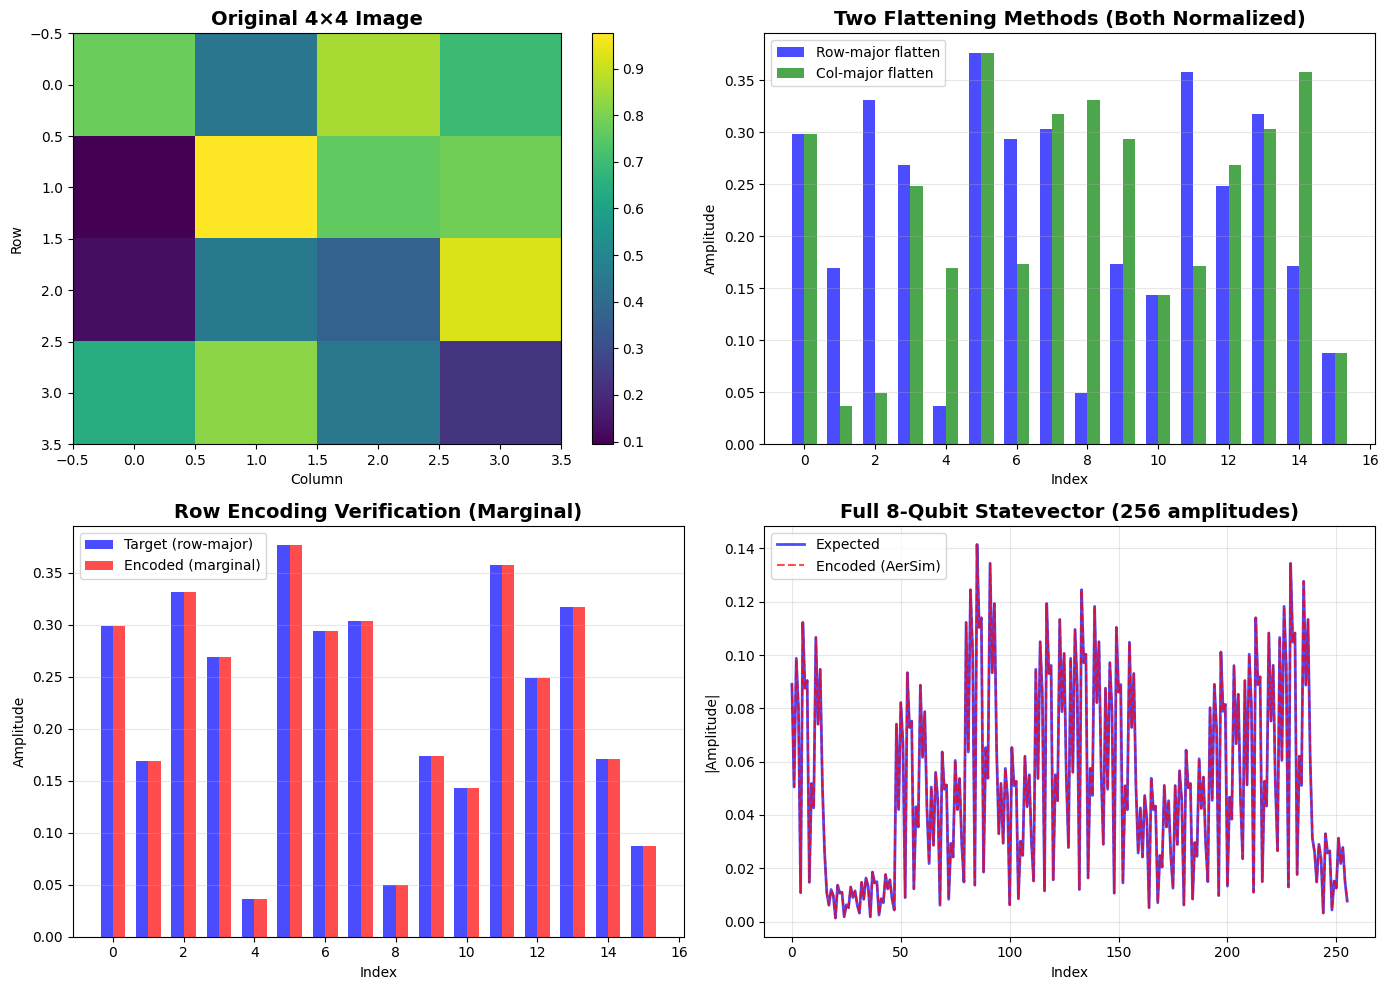


Verification Summary:
Fidelity: 1.000000000000
L2 Error: 8.486e-16
Statevector norm: 1.0000000000
Encoding: First 4 qubits encode row-major, Second 4 encode column-major
Tensor product structure verified!


In [10]:
# Plot the amplitudes to visualize the dual encoding
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original 4x4 image
im0 = axes[0, 0].imshow(test_img, cmap='viridis', aspect='auto')
axes[0, 0].set_title('Original 4×4 Image', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')
plt.colorbar(im0, ax=axes[0, 0])

# Plot 2: Row-major vs column-major flattening comparison
x_pos = np.arange(16)
width = 0.35
axes[0, 1].bar(x_pos - width/2, vec_rows_n.real, width, label='Row-major flatten', alpha=0.7, color='blue')
axes[0, 1].bar(x_pos + width/2, vec_cols_n.real, width, label='Col-major flatten', alpha=0.7, color='green')
axes[0, 1].set_title('Two Flattening Methods (Both Normalized)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Row marginals - trace out columns to see row encoding
rows_marginal = np.zeros(16)
for i in range(256):
    rows_idx = i % 16  # Lower 4 bits (assuming rows=LSB based on verification)
    rows_marginal[rows_idx] += np.abs(sv_dual_array[i])**2
rows_marginal = np.sqrt(rows_marginal)
axes[1, 0].bar(x_pos - width/2, vec_rows_n.real, width, label='Target (row-major)', alpha=0.7, color='blue')
axes[1, 0].bar(x_pos + width/2, rows_marginal, width, label='Encoded (marginal)', alpha=0.7, color='red')
axes[1, 0].set_title('Row Encoding Verification (Marginal)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Full 256-element statevector comparison
axes[1, 1].plot(np.abs(expected_sv), 'b-', label='Expected', alpha=0.7, linewidth=2)
axes[1, 1].plot(np.abs(sv_dual_array), 'r--', label='Encoded (AerSim)', alpha=0.7, linewidth=1.5)
axes[1, 1].set_title('Full 8-Qubit Statevector (256 amplitudes)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('|Amplitude|')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Verification Summary:")
print(f"{'='*60}")
print(f"Fidelity: {fidelity_dual:.12f}")
print(f"L2 Error: {l2_error_dual:.3e}")
print(f"Statevector norm: {np.linalg.norm(sv_dual_array):.10f}")
print(f"Encoding: First 4 qubits encode row-major, Second 4 encode column-major")
print(f"Tensor product structure verified!")
print(f"{'='*60}")